## Library Installation

In [1]:
import sys
sys.version

'3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]'

In [2]:
!pip install -q pyspark

In [3]:
!pip install -q findspark

## Import of Library

In [4]:
import os; 
print(os.getcwd())

C:\Users\nurja\csc7740


In [18]:
# Spark Session created
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("exploratory_data_analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


In [8]:
#spark.stop()

In [7]:
import findspark

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging
import datetime
import sys

In [9]:
import pyspark
print(pyspark.__version__)


3.5.3


In [10]:
import pyspark.sql.functions as F  
from pyspark.sql.functions import col, avg, count, to_date, to_timestamp

## Dataset (.db Format) Load

In [11]:
sqlite_db_path = 'C:\\Users\\nurja\\csc7740\\sqlite_db'


if sqlite_db_path not in sys.path:
    sys.path.append(sqlite_db_path)
    print(f"Added {sqlite_db_path} to sys.path")
    
from sqlite_helpers import Sqlite_db

Added C:\Users\nurja\csc7740\sqlite_db to sys.path


In [12]:
def get_covid_tweets_from_db(database_name, table_name):

    data_dir = 'C:/Users/nurja/csc7740/COVID19MisinformationPaper/themes_of_misinfo_project_tweets/'
    database_path = os.path.join(data_dir,'sqlite_db')
    
    my_db = Sqlite_db(os.path.join(database_path, database_name))
    df = my_db.query(f'select * from {table_name} where "COVID-related"==1')
    my_db.close()

    return df

In [13]:
tweets_df = get_covid_tweets_from_db('tweets_db_2023-03-12_17-57-49.db','raw_tweets') 
tweets_df.shape

Loading: C:/Users/nurja/csc7740/COVID19MisinformationPaper/themes_of_misinfo_project_tweets/sqlite_db\tweets_db_2023-03-12_17-57-49.db


(314534, 16)

In [16]:
## Dataset Coversion from db csv and load

In [14]:
tweets_db_converted= tweets_df.to_csv("tweets.csv", index=False) # Convert db to csv

In [15]:
df = pd.read_csv("tweets.csv")
df.head(1)

,TweetID,UserID,Username,Timestamp,Text,State,County,City,Sentiment,COVID-related,AgeGroup,Age_Confidence,Gender,Gender_Confidence,Org_Confidence,Retweet
0,1240790697504051203,724718492205875203,lionray98,Fri Mar 20 00:02:09 +0000 2020,We learned today that two Lakers players have ...,Louisiana,NaN,NaN,0.7783,1,19-29,0.9404,male,0.9999,0.0,1


In [16]:
state_counts = tweets_df['State'].value_counts()

# Display the result
print(state_counts)

State
Washington    203595
Louisiana     110939
Name: count, dtype: int64


In [19]:
# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(tweets_df)

# Show the Spark DataFrame
spark_df.show(1)

+-------------------+------------------+---------+--------------------+--------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|            TweetID|            UserID| Username|           Timestamp|                Text|    State|County|City|Sentiment|COVID-related|AgeGroup|Age_Confidence|Gender|Gender_Confidence|Org_Confidence|Retweet|
+-------------------+------------------+---------+--------------------+--------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|1240790697504051203|724718492205875203|lionray98|Fri Mar 20 00:02:...|We learned today ...|Louisiana|  NULL|NULL|   0.7783|            1|   19-29|        0.9404|  male|           0.9999|           0.0|      1|
+-------------------+------------------+---------+--------------------+--------------------+---------+------+----+---------+-------------+--------+---------

###### CSV data using spark read, showing data correctly
'''# File path to the CSV file
csv_file = "C:/Users/nurja/csc7740/tweets_db_converted.csv"

Read the CSV file into a DataFrame with additional options
df = spark.read.option("header", True) \
               .option("inferSchema", True) \
               .option("sep", ",") \
               .option("quote", "\"") \
               .option("multiline", True) \
               .csv(csv_file)
df.show(5, truncate=False)'''

## Exploratory Data Analysis

In [20]:
print(spark_df.columns)

['TweetID', 'UserID', 'Username', 'Timestamp', 'Text', 'State', 'County', 'City', 'Sentiment', 'COVID-related', 'AgeGroup', 'Age_Confidence', 'Gender', 'Gender_Confidence', 'Org_Confidence', 'Retweet']


In [21]:
spark_df.printSchema()

root
 |-- TweetID: long (nullable = true)
 |-- UserID: long (nullable = true)
 |-- Username: string (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- State: string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Sentiment: double (nullable = true)
 |-- COVID-related: long (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- Age_Confidence: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Gender_Confidence: string (nullable = true)
 |-- Org_Confidence: string (nullable = true)
 |-- Retweet: long (nullable = true)



In [22]:
spark_df. show(2)

+-------------------+------------------+------------+--------------------+--------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|            TweetID|            UserID|    Username|           Timestamp|                Text|    State|County|City|Sentiment|COVID-related|AgeGroup|Age_Confidence|Gender|Gender_Confidence|Org_Confidence|Retweet|
+-------------------+------------------+------------+--------------------+--------------------+---------+------+----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|1240790697504051203|724718492205875203|   lionray98|Fri Mar 20 00:02:...|We learned today ...|Louisiana|  NULL|NULL|   0.7783|            1|   19-29|        0.9404|  male|           0.9999|           0.0|      1|
|1240790184641335297|          87869624|stephenpomes|Fri Mar 20 00:00:...|By the end of Feb...|Louisiana|  NULL|NULL|  -0.8202|            1|   

In [23]:
# Get the number of rows
num_rows = spark_df.count()
print(f"Number of rows: {num_rows}")

Number of rows: 314534


In [24]:
# Get the number of columns
num_columns = len(spark_df.columns)
print(f"Number of columns: {num_columns}")

Number of columns: 16


In [25]:
spark_df.select( 'TweetID', 'UserID', 'Username', 'Timestamp', 'State', 'County', 'City', 'Sentiment', 'COVID-related').show(5, truncate=False)

+-------------------+------------------+--------------+------------------------------+---------+--------------+-----------+---------+-------------+
|TweetID            |UserID            |Username      |Timestamp                     |State    |County        |City       |Sentiment|COVID-related|
+-------------------+------------------+--------------+------------------------------+---------+--------------+-----------+---------+-------------+
|1240790697504051203|724718492205875203|lionray98     |Fri Mar 20 00:02:09 +0000 2020|Louisiana|NULL          |NULL       |0.7783   |1            |
|1240790184641335297|87869624          |stephenpomes  |Fri Mar 20 00:00:07 +0000 2020|Louisiana|NULL          |NULL       |-0.8202  |1            |
|1240790198906126336|1290387876        |kimberlyjanise|Fri Mar 20 00:00:10 +0000 2020|Louisiana|Caddo Parish  |Shreveport |-0.4812  |1            |
|1240790231198191616|1681716134        |fwJermon      |Fri Mar 20 00:00:18 +0000 2020|Louisiana|Madison Parish|T

In [26]:
spark_df.select( 'AgeGroup',  'Age_Confidence','Gender', 'Gender_Confidence', 'Org_Confidence' , 'Retweet' ).show(5,truncate=False)

+--------+--------------+------+-----------------+--------------+-------+
|AgeGroup|Age_Confidence|Gender|Gender_Confidence|Org_Confidence|Retweet|
+--------+--------------+------+-----------------+--------------+-------+
|19-29   |0.9404        |male  |0.9999           |0.0           |1      |
|>=40    |0.9958        |male  |0.9997           |0.3325        |1      |
|30-39   |0.4522        |female|0.9928           |0.0001        |0      |
|30-39   |0.68          |male  |0.9989           |0.0           |1      |
|19-29   |0.5653        |female|0.9424           |0.0           |1      |
+--------+--------------+------+-----------------+--------------+-------+
only showing top 5 rows



In [27]:
spark_df.select('Text').show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Text                                                                                                                                                                                                                                                                                                                |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|We learned today that two Lakers players have tested positive for 

In [28]:
from pyspark.sql import functions as F

# Count nulls in each column
null_counts = spark_df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in spark_df.columns])

# Show the result
null_counts.show()


+-------+------+--------+---------+----+-----+------+-----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|TweetID|UserID|Username|Timestamp|Text|State|County| City|Sentiment|COVID-related|AgeGroup|Age_Confidence|Gender|Gender_Confidence|Org_Confidence|Retweet|
+-------+------+--------+---------+----+-----+------+-----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+
|      0|     0|       0|        0|   0|    0| 42246|42246|        0|            0|       0|             0|     0|                0|             0|      0|
+-------+------+--------+---------+----+-----+------+-----+---------+-------------+--------+--------------+------+-----------------+--------------+-------+



In [29]:
# Count the number of rows for each state
state_counts = spark_df.groupBy('State').count()
# Show the result
state_counts.show(truncate=False)


+----------+------+
|State     |count |
+----------+------+
|Louisiana |110939|
|Washington|203595|
+----------+------+



In [30]:
# Count the number of rows based on gender
gender_counts = spark_df.groupBy('Gender').count()
# Show the result
gender_counts.show(truncate=False)

+------+------+
|Gender|count |
+------+------+
|None  |25870 |
|female|139194|
|male  |149470|
+------+------+



In [31]:
# Most Active Users
active_users = spark_df.groupBy("Username").agg(count("TweetID").alias("TweetCount")).orderBy(col("TweetCount").desc())
active_users.show()

+---------------+----------+
|       Username|TweetCount|
+---------------+----------+
|forcemultstevea|      1236|
|      Scout2462|       832|
|      Wrennie11|       612|
|  LoveNOLA4ever|       574|
|     NanaB_2010|       551|
|  dontpanic1955|       542|
|    sharonflink|       518|
|        rrnunez|       489|
|MicheleJeanson1|       485|
|jameskthompson1|       481|
| MYMIMISTHEBEST|       478|
|      Kat4Obama|       473|
|      akkaufman|       466|
|         remu10|       456|
|    WillSeattle|       430|
|  straitarrow10|       388|
|  princesshoped|       363|
|     ninnynoomy|       356|
|Kristie58407111|       347|
|   Gwendolyn679|       342|
+---------------+----------+
only showing top 20 rows



In [32]:
spark_df.describe().show()  # Check statistics and null counts

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-------------+---------+--------------------+-------------+--------+-------------------+------+-------------------+-------------------+-------------------+
|summary|             TweetID|              UserID|            Username|           Timestamp|                Text|     State|       County|     City|           Sentiment|COVID-related|AgeGroup|     Age_Confidence|Gender|  Gender_Confidence|     Org_Confidence|            Retweet|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-------------+---------+--------------------+-------------+--------+-------------------+------+-------------------+-------------------+-------------------+
|  count|              314534|              314534|              314534|              314534|              314534|    314534|       272288|   272288|        

In [33]:
# Show the top 5 Tweet IDs
top_tweet_ids = spark_df.select("TweetID").limit(5)
top_tweet_ids.show(truncate=False)

+-------------------+
|TweetID            |
+-------------------+
|1240790697504051203|
|1240790184641335297|
|1240790198906126336|
|1240790231198191616|
|1240790885463449600|
+-------------------+



In [34]:
# Show the top 5 User IDs
top_user_ids = spark_df.select("UserID").limit(5)
top_user_ids.show(truncate=False)

+------------------+
|UserID            |
+------------------+
|724718492205875203|
|87869624          |
|1290387876        |
|1681716134        |
|3006098420        |
+------------------+



In [35]:
display(gender_counts)

DataFrame[Gender: string, count: bigint]

In [36]:
# Count distinct values in the COVID-related field
distinct_covid_related_count = spark_df.select('COVID-related').distinct().count()

# Show the result
print(f"Number of distinct values in the COVID-related field: {distinct_covid_related_count}")


Number of distinct values in the COVID-related field: 1


In [37]:
# Count distinct values in the AgeGroup_count field
distinct_AgeGroup_count = spark_df.select('AgeGroup').distinct().count()

# Show the result
print(f"Number of distinct values in the Age-group field: {distinct_AgeGroup_count}")


Number of distinct values in the Age-group field: 5


In [38]:
# Count the number of rows based on Age
AgeGroup_counts = spark_df.groupBy('AgeGroup').count()
# Show the result
AgeGroup_counts.show(truncate=False)

+--------+------+
|AgeGroup|count |
+--------+------+
|19-29   |80346 |
|None    |25870 |
|30-39   |56262 |
|>=40    |117510|
|<=18    |34546 |
+--------+------+



In [39]:
# Count distinct values in the Retweet_count field
distinct_Retweet_count = spark_df.select('Retweet').distinct().count()

# Show the result
print(f"Number of distinct values in the Age-group field: {distinct_Retweet_count}")


Number of distinct values in the Age-group field: 2


In [40]:
# Count the number of rows based on Age
Retweet_counts = spark_df.groupBy('Retweet').count()
# Show the result
Retweet_counts.show(truncate=False)

+-------+------+
|Retweet|count |
+-------+------+
|0      |81126 |
|1      |233408|
+-------+------+



In [41]:
# Count distinct values in the Retweet_count field
distinct_UserID_count = spark_df.select('UserID').distinct().count()

# Show the result
print(f"Number of distinct values in the UserID field: {distinct_UserID_count}")

Number of distinct values in the UserID field: 71309


In [42]:
# Count the number of rows based on Age
UserID_counts = spark_df.groupBy('UserID').count()
# Show the result
UserID_counts.show(truncate=False)

+-------------------+-----+
|UserID             |count|
+-------------------+-----+
|1169249008570818564|11   |
|1008596844123951105|9    |
|250789889          |4    |
|71654528           |10   |
|1226130919         |129  |
|266867116          |1    |
|368685662          |2    |
|31206491           |4    |
|418798307          |1    |
|4104737894         |2    |
|14311562           |2    |
|236268874          |3    |
|1250482915         |2    |
|2969168591         |1    |
|61269019           |2    |
|232110275          |3    |
|16999585           |4    |
|22490031           |5    |
|34130393           |1    |
|622246397          |1    |
+-------------------+-----+
only showing top 20 rows



In [43]:
# Using SQL for aggregations
spark_df.createOrReplaceTempView("tweets")
result = spark.sql("SELECT State, COUNT(*) as tweet_count FROM tweets GROUP BY State")
result.show()

+----------+-----------+
|     State|tweet_count|
+----------+-----------+
| Louisiana|     110939|
|Washington|     203595|
+----------+-----------+



In [44]:
# Count the number of rows based on gender
gender_counts = spark_df.groupBy('Gender').count()

# Show the results
gender_counts.show()

+------+------+
|Gender| count|
+------+------+
|  None| 25870|
|female|139194|
|  male|149470|
+------+------+



## Visualization using Seaborn and matplotlib using Spark Dataframe

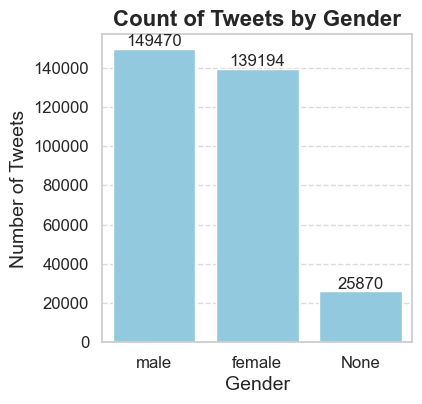

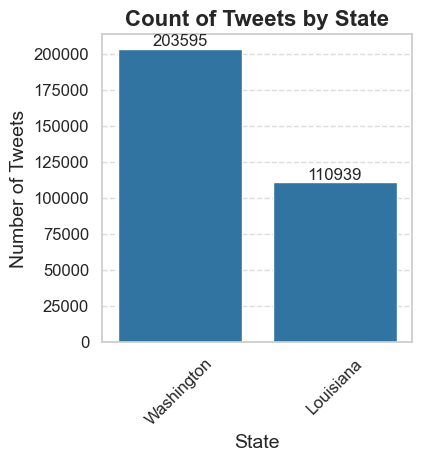

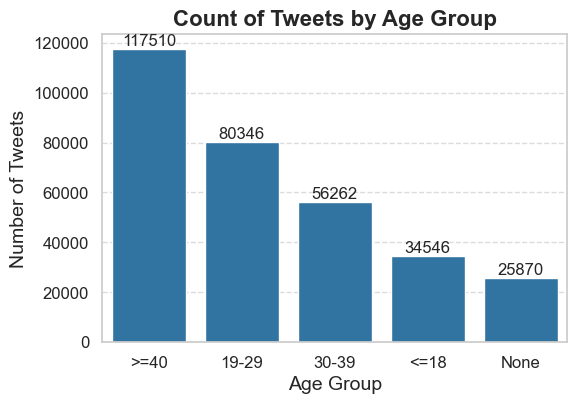

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Set the Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Count of tweets by Gender
gender_counts = spark_df.groupBy('Gender').count().orderBy('count', ascending=False)
gender_counts_collected = gender_counts.collect()
gender_labels = [row['Gender'] for row in gender_counts_collected]
gender_values = [row['count'] for row in gender_counts_collected]

# Plotting count of tweets by Gender
plt.figure(figsize=(4, 4))
bar_gender = sns.barplot(x=gender_labels, y=gender_values, color='skyblue')
plt.title('Count of Tweets by Gender', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding counts on each bar
for p in bar_gender.patches:
    bar_gender.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=12)

plt.show()

# Count of tweets by State
state_counts = spark_df.groupBy('State').count().orderBy('count', ascending=False)
state_counts_collected = state_counts.collect()
state_labels = [row['State'] for row in state_counts_collected]
state_values = [row['count'] for row in state_counts_collected]

# Plotting count of tweets by State
plt.figure(figsize=(4, 4))
bar_state = sns.barplot(x=state_labels, y=state_values, color='#1f77b4')
plt.title('Count of Tweets by State', fontsize=16, fontweight='bold')
plt.xlabel('State', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding counts on each bar
for p in bar_state.patches:
    bar_state.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=12)

plt.show()

# Count of tweets by Age Group
age_group_counts = spark_df.groupBy('AgeGroup').count().orderBy('count', ascending=False)
age_group_counts_collected = age_group_counts.collect()
age_group_labels = [row['AgeGroup'] for row in age_group_counts_collected]
age_group_values = [row['count'] for row in age_group_counts_collected]

# Plotting count of tweets by Age Group
plt.figure(figsize=(6, 4))
bar_age_group = sns.barplot(x=age_group_labels, y=age_group_values, color='#1f77b4')
plt.title('Count of Tweets by Age Group', fontsize=16, fontweight='bold')
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding counts on each bar
for p in bar_age_group.patches:
    bar_age_group.annotate(format(p.get_height(), '.0f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='bottom', fontsize=12)

plt.show()


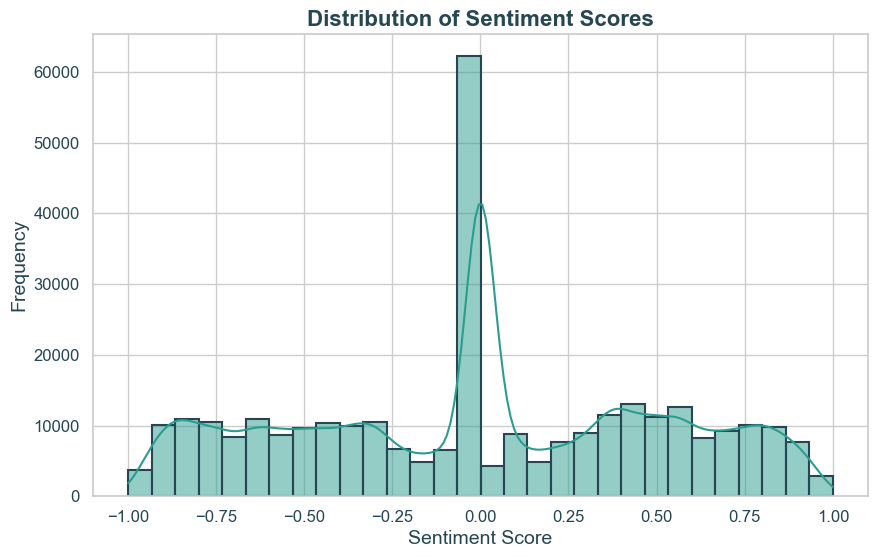

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a modern style
sns.set(style="whitegrid")

# Collect sentiment scores from Spark DataFrame to a list
sentiment_scores = [row['Sentiment'] for row in spark_df.select('Sentiment').collect()]

# Plotting the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(sentiment_scores, bins=30, kde=True, color='#2a9d8f', edgecolor='#264653', linewidth=1.5)

# Add labels and a title
plt.title('Distribution of Sentiment Scores', fontsize=16, fontweight='bold', color='#264653')
plt.xlabel('Sentiment Score', fontsize=14, color='#264653')
plt.ylabel('Frequency', fontsize=14, color='#264653')

# Customize ticks
plt.xticks(fontsize=12, color='#264653')
plt.yticks(fontsize=12, color='#264653')

# Show the plot
plt.show()


## Spark Dataframe to Panda Dataframe, Then matplotlib for visualization
#### Did all visualization using spark dataframe, but to get colorful dataframe, now using converting to panda

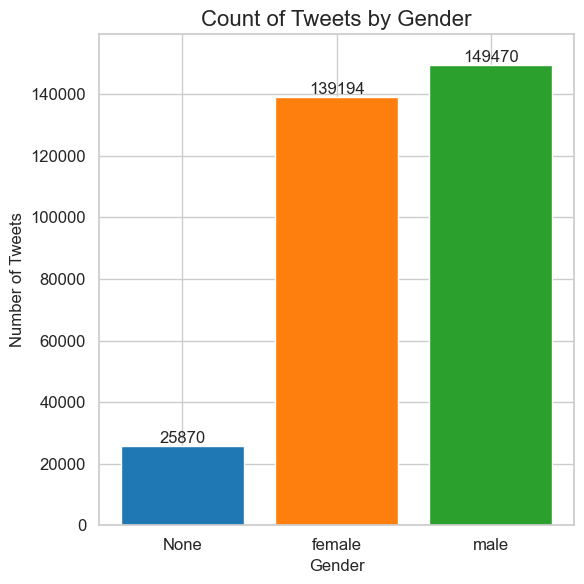

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect gender counts dynamically from Spark DataFrame
gender_counts = spark_df.groupBy('Gender').count()
results = gender_counts.collect()

# Prepare the data for matplotlib
gender_labels = [row['Gender'] for row in results]
counts = [row['count'] for row in results]

# Create a DataFrame
data = pd.DataFrame({'Gender': gender_labels, 'Count': counts})

# Plot using matplotlib
plt.figure(figsize=(6, 6))

# Create the bar chart
bars = plt.bar(data['Gender'], data['Count'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Customize the chart
plt.title('Count of Tweets by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.ylim(0, max(counts) + 10000)  # Adjust the y-axis range based on the counts dynamically
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the chart
plt.show()


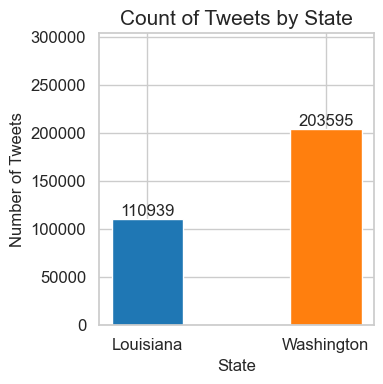

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Count the number of rows based on state dynamically
state_counts = spark_df.groupBy('State').count()

# Collect the results
results = state_counts.collect()

# Prepare data for plotting
state_labels = [row['State'] for row in results]
counts = [row['count'] for row in results]

# Create a DataFrame for Matplotlib
data = pd.DataFrame({'State': state_labels, 'Count': counts})

# Create the bar chart using Matplotlib
plt.figure(figsize=(4, 4))  # Decrease figure width (e.g., 8) and height (e.g., 4)

# Create the bar chart with adjusted width
bar_width = 0.4  # Adjust this value to decrease bar size
bars = plt.bar(data['State'], data['Count'], width=bar_width, color=plt.cm.tab10.colors)

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Customize the chart
plt.title('Count of Tweets by State', fontsize=15)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.ylim(0, max(counts) + 100000)  # Adjust the y-axis range based on counts dynamically
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the chart
plt.show()


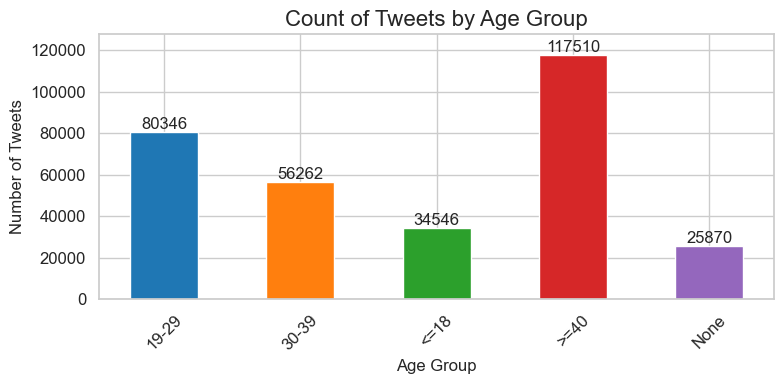

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Count the number of rows based on age group dynamically
age_group_counts = spark_df.groupBy('AgeGroup').count()

# Collect the results
results = age_group_counts.collect()

# Prepare data for plotting
age_group_labels = [row['AgeGroup'] for row in results]
counts = [row['count'] for row in results]

# Create a DataFrame for Matplotlib
data = pd.DataFrame({'Age Group': age_group_labels, 'Count': counts})

# Sort the DataFrame based on the Age Group
data = data.sort_values('Age Group')

# Create the bar chart using Matplotlib
plt.figure(figsize=(8, 4))  # Set the desired overall width and height of the chart

# Create the bar chart with adjusted width
bar_width = 0.5  # Adjust this value to change the size of the bars
bars = plt.bar(data['Age Group'], data['Count'], width=bar_width, color=plt.cm.tab10.colors)

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Customize the chart
plt.title('Count of Tweets by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.ylim(0, max(counts) + 10000)  # Adjust the y-axis range based on counts dynamically
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout
plt.tight_layout()

# Show the chart
plt.show()


In [54]:
!pip install -q nbformat

In [1]:

import nbformat

# Load the notebook file
with open('exploratory_data_analysis.ipynb', 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Count the lines of code in all code cells
code_lines = 0
for cell in notebook['cells']:
    if cell['cell_type'] == 'code':
        code_lines += len(cell['source'].splitlines())

print(f"Total lines of code: {code_lines}")


Total lines of code: 419


In [4]:
import json

def count_spark_operations(notebook_path):
    # Open the notebook file with utf-8 encoding
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    spark_operation_count = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code = cell['source']
            # Check for common Spark operation keywords
            for line in code:
                if any(op in line for op in ['filter', 'select', 'groupBy', 'join', 'map', 'reduce', 'show', 'collect']):
                    spark_operation_count += 1

    return spark_operation_count

# Example usage
notebook_path = 'exploratory_data_analysis.ipynb'  # Update this with your notebook path
operation_count = count_spark_operations(notebook_path)
print(f"Number of Spark Operations Found: {operation_count}")


Number of Spark Operations Found: 61
